# Generate Data

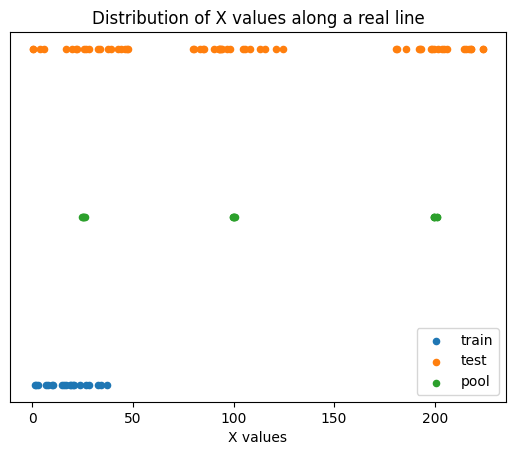

In [1]:
#run below code twice
from line_profiler import LineProfiler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import plotnine as gg
import torch
import torch.optim as optim

from torch import nn
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import pandas as pd
import warnings
import gpytorch
warnings.filterwarnings('ignore')

import pipeline_var_l2_loss
import seaborn as sns
from dataloader import TabularDataset
from var_l2_loss_estimator import *
from ENN import basenet_with_learnable_epinet_and_ensemble_prior

num_init_train_samples = 20
num_pool_samples = 5
num_test_samples = 20

input_dim = 1

init_train_x = torch.rand((num_init_train_samples, input_dim))*50.0

test_x_1 = torch.rand((num_test_samples, input_dim))*50.0
test_x_2 = 75.0 + torch.rand((num_test_samples, input_dim))*50.0
test_x_3 = 175.0 + torch.rand((num_test_samples, input_dim))*50.0

test_x = torch.cat([test_x_1,test_x_2,test_x_3])

pool_x_1 = 24 + torch.rand((num_pool_samples, input_dim))*2
pool_x_2 = 99 + torch.rand((num_pool_samples, input_dim))*2
pool_x_3 = 199 + torch.rand((num_pool_samples, input_dim))*2

pool_x = torch.cat([pool_x_1,pool_x_2,pool_x_3])

x = torch.cat([init_train_x,test_x,pool_x])
y = torch.zeros(num_init_train_samples+3*num_pool_samples+3*num_test_samples)

init_train_x_numpy = init_train_x.numpy()
init_train_y = torch.zeros(init_train_x.size(0))
test_x_numpy = test_x.numpy()
test_y = torch.ones(test_x.size(0))
pool_x_numpy = pool_x.numpy()
pool_y = torch.empty(pool_x.size(0)).fill_(0.5)


plt.scatter(init_train_x_numpy, init_train_y.numpy(), s=20, label='train')
plt.scatter(test_x_numpy, test_y.numpy(), s=20, label='test')
plt.scatter(pool_x_numpy, pool_y.numpy(), s=20, label='pool')

plt.yticks([])  # Hide y-axis ticks
plt.xlabel('X values')
plt.legend()
plt.title('Distribution of X values along a real line')
plt.show()

# Gaussian Process Definition

In [2]:
# Define parameters for the model
mean_constant = 0.0  # Mean of the GP
length_scale = 25.0   # Length scale of the RBF kernel
noise_std = 0.01     # Standard deviation of the noise


mean_module = gpytorch.means.ConstantMean()
base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()


mean_module.constant = mean_constant
base_kernel.base_kernel.lengthscale = length_scale
likelihood.noise_covar.noise = noise_std**2

class CustomizableGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, mean_module, base_kernel, likelihood):
        super(CustomizableGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = base_kernel
        self.likelihood = likelihood

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean_module(x), self.covar_module(x))


model = CustomizableGPModel(x, y, mean_module, base_kernel, likelihood)

torch.manual_seed(1)
# Sample from the prior for training data
model.eval()
likelihood.eval()
with torch.no_grad():
    prior_dist = likelihood(model(x))
    y_new = prior_dist.sample()

# ENN code

In [6]:

class TabularDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]


    
def ENN_training(x_train, y_train,model_config, train_config, enn_config, device, if_print):
    
    dataset_train = TabularDataset(x = x_train, y = y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=model_config.batch_size_train, shuffle=True) 
    sample, label = dataset_train[0]
    input_feature_size = sample.shape[0]  
    
     # to_device
    ENN = basenet_with_learnable_epinet_and_ensemble_prior(input_feature_size, enn_config.basenet_hidden_sizes, model_config.n_classes, enn_config.exposed_layers, enn_config.z_dim, enn_config.learnable_epinet_hiddens, enn_config.hidden_sizes_prior, enn_config.seed_base, enn_config.seed_learnable_epinet, enn_config.seed_prior_epinet, enn_config.alpha).to(device)


    loss_fn_init = nn.MSELoss()
    optimizer_init = optim.Adam(ENN.parameters(), lr=model_config.init_train_lr, weight_decay=model_config.init_train_weight_decay)
    # ------- seed for this training
    # ------- train ENN on initial training data  # save the state - ENN_initial_state  # define a separate optimizer for this # how to sample z's ---- separately for each batch
    # ------- they also sampled the data each time and not a dataloader - kind of a bootstrap
    #print('ENN model weights',ENN.learnable_epinet_layers[0].weight)
    enn_loss_list = []
    for i in range(model_config.n_train_init):
        ENN.train()
        for (inputs, labels) in dataloader_train:
            #inputs, labels =  inputs.to(device), labels.to(device)
            z = torch.randn(enn_config.z_dim, device=device)   #set seed for this  #set to_device for this
            optimizer_init.zero_grad()
            outputs = ENN(inputs,z)

            #labels = torch.tensor(labels, dtype=torch.long, device=device)
            loss = loss_fn_init(outputs, torch.squeeze(labels))
            if if_print == 1:
                pass
                #print("ENN_init_loss:",loss)
            loss.backward()
            optimizer_init.step()

        enn_loss_list.append(float(loss.detach().to('cpu').numpy())) 
    if if_print == 1:
        plt.plot(list(range(len(enn_loss_list))),enn_loss_list)
        plt.title('ENN loss vs training iter')
        plt.show()
    
    return ENN

# x_train, y_train = x[:num_init_train_samples], y_new[:num_init_train_samples]
# ENN_trained = ENN_training(x_train, y_train, model_cfg, train_cfg, enn_cfg, device , if_print = 0 )

# GP training using training_inference

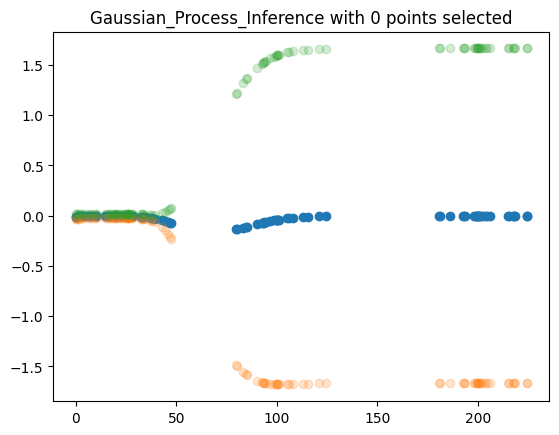

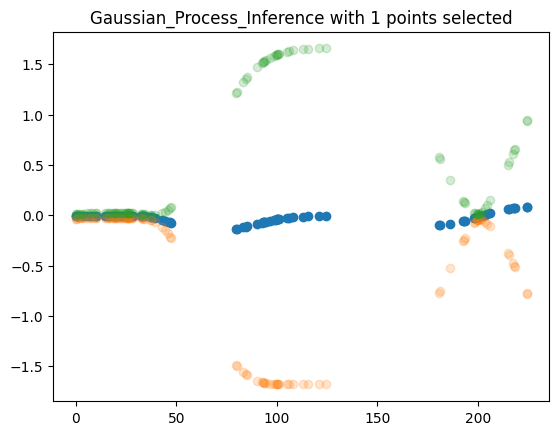

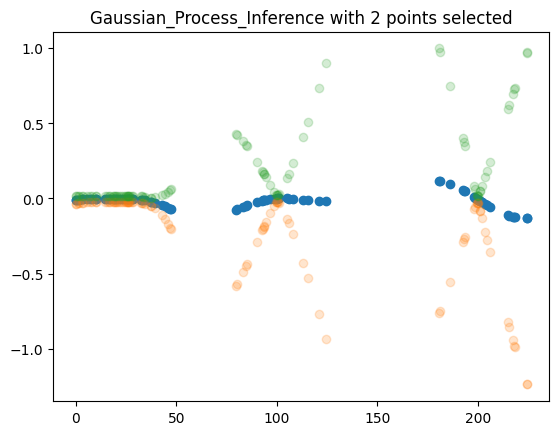

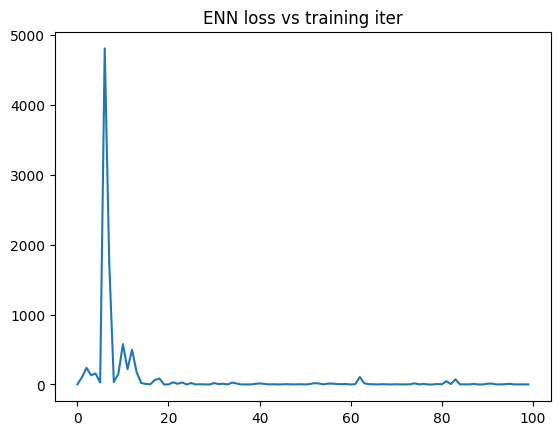

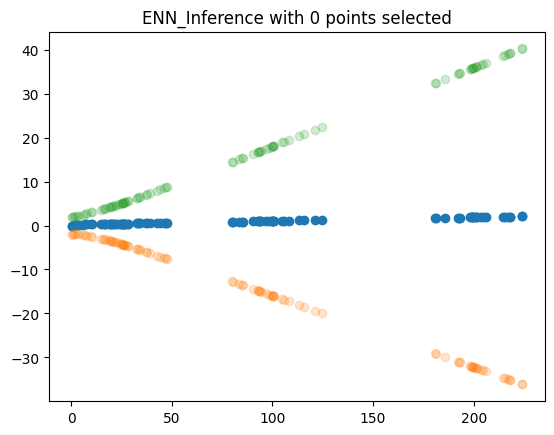

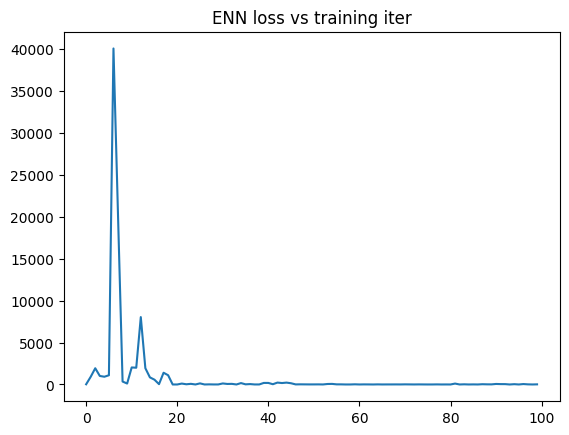

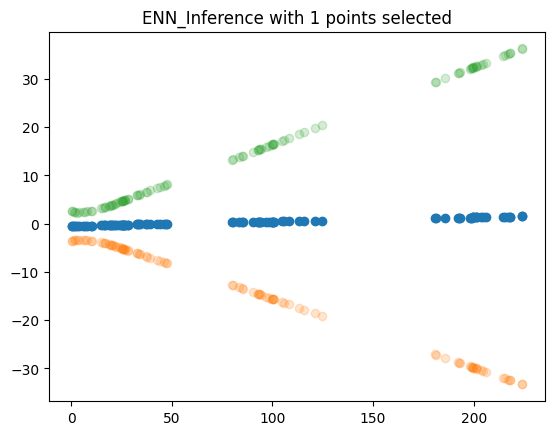

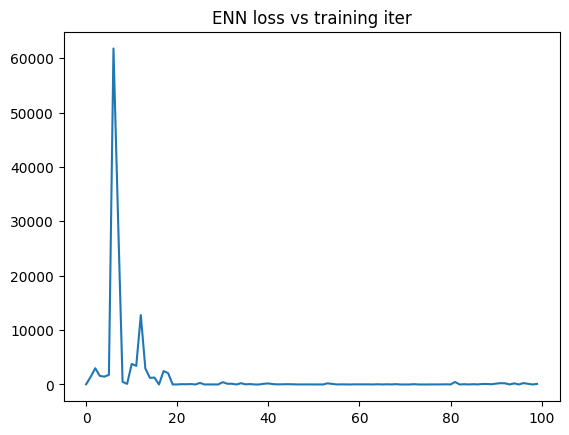

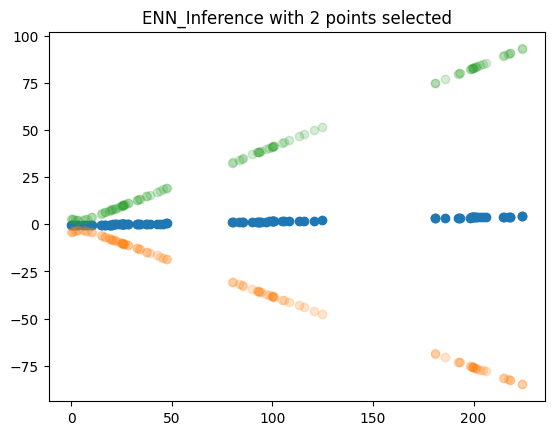

In [9]:
Z_dim = 4
model_cfg = pipeline_var_l2_loss.ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.01, n_classes = 1, n_epoch = 5, init_train_lr = 0.05, init_train_weight_decay = 0.01, n_train_init = 100, meta_opt_weight_decay = 0.01)
train_cfg = pipeline_var_l2_loss.TrainConfig(n_train_iter = 500, n_ENN_iter = 1000, ENN_opt_lr = 0.01, N_iter_noise = 10, sigma_noise = 0.5, seed_var_l2 = 123, z_dim = Z_dim, N_iter = 100, ENN_opt_weight_decay = 0.01) #temp_var_recall is the new variable added here
enn_cfg = pipeline_var_l2_loss.ENNConfig(basenet_hidden_sizes = [50,50],  exposed_layers = [False, True], z_dim = Z_dim, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5,5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 1.0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def Inference(UQ_module, Option, if_print, UQ_parameter = []):
    if Option == 0: #only training 
        x_train, y_train = x[:num_init_train_samples], y_new[:num_init_train_samples]
    elif Option == 1: # select 2nd point
        x_train = torch.cat([x[:num_init_train_samples],x[-2:]])
        y_train = torch.cat([y_new[:num_init_train_samples],y_new[-2:]])
    elif Option == 2:
        x_train = torch.cat([x[:num_init_train_samples],x[num_init_train_samples+num_test_samples*3+num_pool_samples+1:num_init_train_samples+num_test_samples*3+num_pool_samples*2+2],x[-1:]])
        y_train = torch.cat([y_new[:num_init_train_samples],y[num_init_train_samples+num_test_samples*3+num_pool_samples+1:num_init_train_samples+num_test_samples*3+num_pool_samples*2+2],y_new[-1:]])

    #print(x_train.shape, y_train.shape)
    if UQ_module == 'Gaussian_Process':
        model.set_train_data(inputs = x_train, targets = y_train, strict=False)       ####### CAN ALSO USE TRAINING OVER NLL HERE########

        ### IMP LINK - https://github.com/cornellius-gp/gpytorch/issues/1409
        ### IMP LINK - https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
        posterior = likelihood(model(x))
        posterior_mean = posterior.mean
        posterior_std = torch.sqrt(posterior.variance)
    elif UQ_module == 'ENN':
        ENN_trained = ENN_training(x_train, y_train, model_cfg, train_cfg, enn_cfg, device , if_print )
        N_iter = UQ_parameter['N_iter_ENN']
        torch.manual_seed(1)
        prediction_list = torch.empty((0), dtype=torch.float32, device=device)

        for i in range(N_iter): 
            z_pool = torch.randn(Z_dim, device=device) 
            prediction = ENN_trained(x, z_pool) #x is all data
            prediction_list = torch.cat((prediction_list,prediction),1)

        posterior_mean = torch.mean(prediction_list, axis = 1)
        posterior_std = torch.std(prediction_list, axis = 1)

 
    plt.scatter(x,posterior_mean.detach().numpy())
    plt.scatter(x.squeeze(),posterior_mean.detach().numpy()-2*posterior_std.detach().numpy(),alpha=0.2)
    plt.scatter(x.squeeze(),posterior_mean.detach().numpy()+2*posterior_std.detach().numpy(),alpha=0.2)
    #plt.ylim(-2, 2)
    plt.title(UQ_module + '_Inference with ' + str(Option) +' points selected')
    plt.show()

UQ_parameter = {'N_iter_ENN':100}
for UQ_module in ['Gaussian_Process','ENN']:
    for Option in range(3):
        Inference(UQ_module, Option, UQ_parameter = UQ_parameter, if_print = 1)